# HOST

**Author:** _Matteo Bagagli_ - **Date:** _10/2021_ - **Version:** _2.2.1_

-------------------------------------------------------------------------------------------------------------------

The **HOST** acronym stands for **H**igh-**O**rder-**ST**atistics seismic pickers.
This algorithm took inspiration from the one described in [_Baillard et al. 2014_](10.1785/0120120347). 
The idea behing this package is to provide user-friendly classes for seismic phase picking with _skewness_ and _kurtosis_ carachteristic-functions. I

Originally applied to seismograms by [_Saragiotis et al._](10.1109/TGRS.2002.800438), the HOS-CF are able to detect energic transient when the statistical properties of a seismogram (or time series) change abruptly. These CF are calculated on moving window with fixed window.

Measurements of statistical properties in a moving window are suitable for frequency-specific (or expected) transient. For this reason, the picker support a multi-window analysis, in order to collecto more information or even increase the quality of about 

Both _skewness_ and _kurtosis_ are calculated with C-routine under the hood, making this package fast and suitable also for realtime picking porpouses.

For the installation please refer to the `README.md` file in the project-home (for both standard and developer installation)


### Skewness CF

The skewness is defined as follows, using the 3rd central-moment third central moment of a continous distribution. 

$$
S=\frac{E\left[(X-E[X]]^{3}\right.}{E[X-E[X]]^{3 / 2}}=\frac{m_{3}}{m_{2}^{3 / 2}}
$$

The skewness provides information about positive or negative deviations of the distribution density function from the expectation value.

### Kurtosis CF

The kurtosis is defined as follows, using the 4th central-moment third central moment of a continous distribution. 

$$
K=\frac{E\left[(X-E[X]]^{4}\right.}{E[X-E[X]]^{4 / 2}}=\frac{m_{4}}{m_{2}^{2}}
$$

The kurtosis provides information about only positive deviations of the distribution density function from the expectation value.

# Transformer
-------------------------------------------------------

An additional feature provide by this package is the possibility to trasform the HOS-CF in order to get a more precise phase pick depending on data's nature and main feature, let's analyze them:

First, let's import the `ObsPy` library and the package main class `Host`. 
This time we also need to import the `scaffold` module, that contains all the necessary transformation. Once loaded the waveform, we do a first standard pre-processing of the data.

In [1]:
# ----------------------------------------  To work
import sys
import logging
from obspy import read, UTCDateTime
from host.picker import Host
from host.plotting import plot_HOST
from host import scaffold as HSC

# ----------------------------------------  To show and log
%matplotlib inline 
import matplotlib.pyplot as plt
logger = logging.getLogger()
logger.setLevel(logging.INFO)


def miniproc(st):
    prs = st.copy()
    prs.detrend('demean')
    prs.detrend('simple')
    prs.taper(max_percentage=0.05, type='cosine')
    prs.filter("bandpass",
               freqmin=1,
               freqmax=30,
               corners=2,
               zerophase=True)
    return prs

straw = read("../tests_data/obspy_read.mseed")
stproc = miniproc(straw)
trproc = stproc.select(channel="*Z")[0]
tr = trproc.copy()

As the trace contains the entire waveforms, we want to get close to the real onset ...

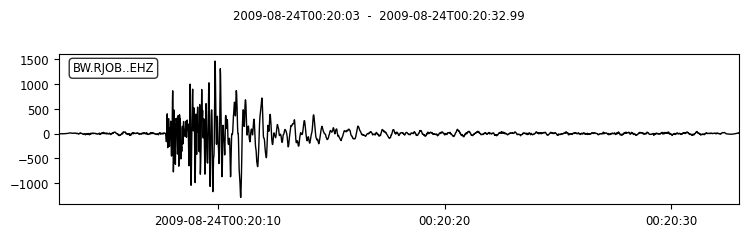

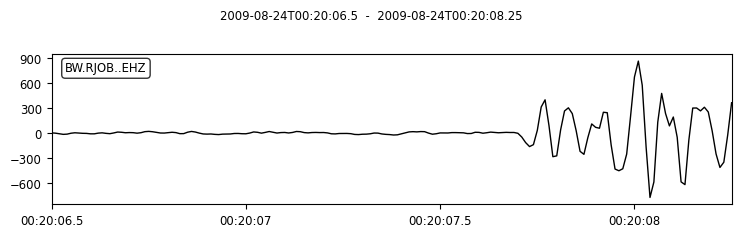

In [2]:
# Entire wave
tr.plot()

# Trimming
tr.trim(UTCDateTime("2009-08-24T00:20:06.500000"),
        UTCDateTime("2009-08-24T00:20:08.250000"))

tr.plot();


Now we want to initialize the main picker object, by providing the processed trace and the time-window (in seconds) for the CF calculation, and the `hos_method`. For the porpouse of demonstration, we will use the `'kurt'` option ...

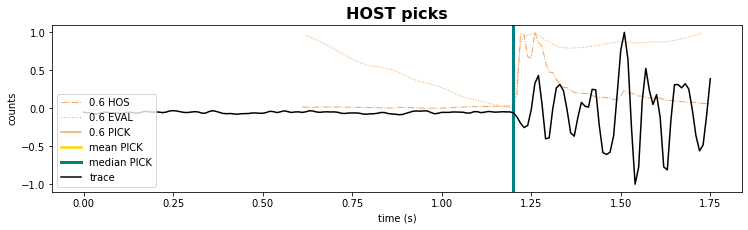

In [3]:
HP = Host(tr, 0.6, hos_method='kurtosis')  # also 'kurt' and 'k' works ... 
HP.work(debug_plot=True)

### Transformation - F2

Such a transformation is the one proposed in _Baillard et al. 2014_. It will create a _stair-like_ function of the time-series energy...the `AIC` method though, is still unable to see the correct onset due to the higher-energy secondary arrival.

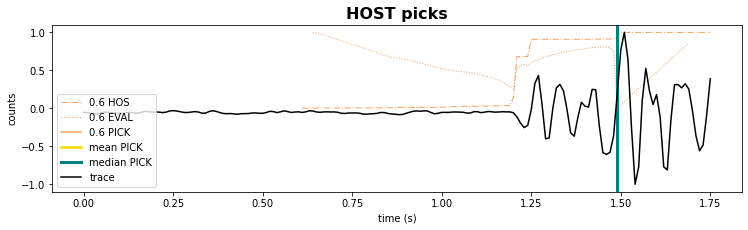

In [4]:
HP.set_transform_cf(
    {
        'transform_f2': {}  # this function is non-parametric
    }
)
HP.work(debug_plot=True)

### Transformation - F3
Such a transformation is also similar to the one proposed in _Baillard et al. 2014_. It is just a **detrending-function**.

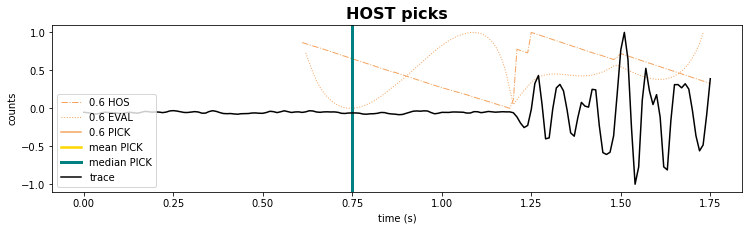

In [5]:
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {}   # this function is non-parametric      
    }
)
HP.work(debug_plot=True)

... as you see, the AIC function now have problem detecting the true onset because the transformed CF is not indicated for this change. With the `min` detection system, though, the onset detection is now even more precise than the simple `kurt/skew` + `AIC`. 


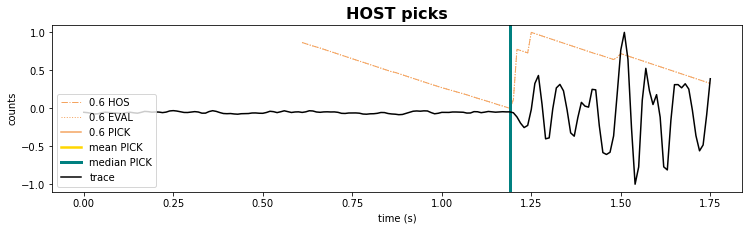

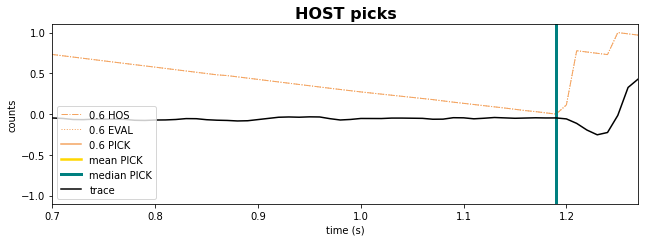

In [6]:
HP.set_detection_method('min')
HP.work(debug_plot=True)

# Zooming in ...
ax = plot_HOST(
  HP,
  normalize=True,
  debug_plot=True,
  plot_final_picks=True,
  axtitle="HOST picks",
  show=False)
ax[1].set_xlim([0.7, 1.27])
plt.show()


### Transformation - F4

Such a transformation is also similar to the one proposed in _Baillard et al. 2014_. This function is **pushing down local minima** for an easier detection with the `min` method.


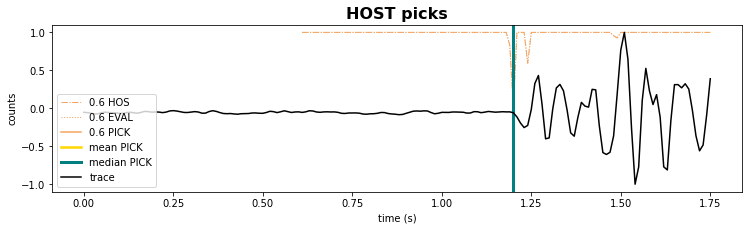

In [7]:
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_f4': {}   # this function is non-parametric         
    }
)
HP.work(debug_plot=True)

### Additional Transformation:

Additional transformations are:

- `transform_f5`: elevate the array to specified power (default 2.0). This step should help increase the S/N ratio.

- `transform_smooth_full`: smooth the CF with a fixed window-length equal to the CF-length (samples) and a `window_type` for the filtering (default `hanning`).

- `transform_smooth_custom`: smooth the CF with a custom window-length specified (in seconds) and a `window_type` for the filtering (default `hanning`). 

For the possible parameter selection and their explanations, please refer to the documentation.


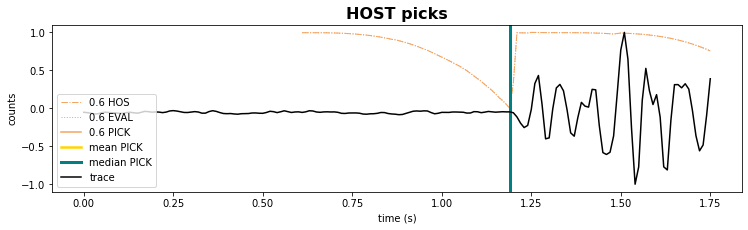

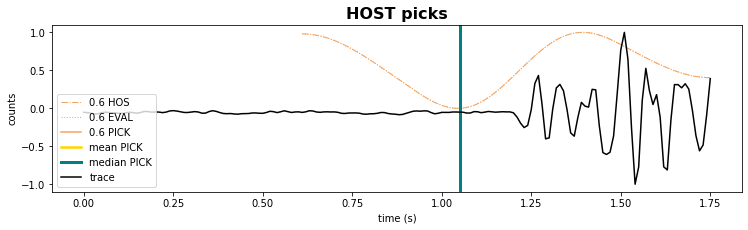

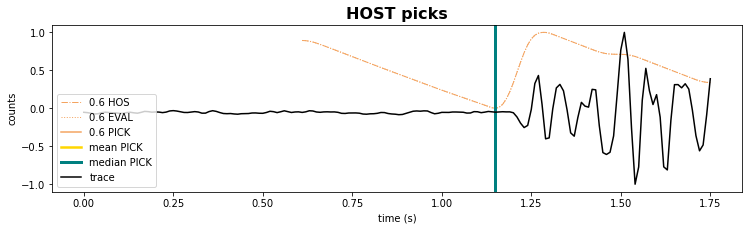

In [8]:
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_f5': {'power': 3.0}         
    }
)
HP.work(debug_plot=True)

# Or if we use the smooth FULL ...
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_smooth_full': {'window_type': 'hanning'}  # 'flat', 'hanning', 'hamming',
                                                             # 'bartlett', 'blackman'
    }
)
HP.work(debug_plot=True)

# Or if we use the smooth CUSTOM ...
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_smooth_custom': {'smooth_win': 0.15,
                                    'window_type': 'hanning'}  # 'flat', 'hanning',
                                                               # 'hamming', 'bartlett',
                                                               # 'blackman'
    }
)
HP.work(debug_plot=True)


Of course these `smoothing*` function are here to show the functionality, they are not really handy in this easy case scenario were one (or even none) CF transformations would be needed ...

### References
- Baillard, C., Crawford, W.C., Ballu, V., Hibert, C. and Mangeney, A., 2014. An automatic kurtosis‐based P‐and S‐phase picker designed for local seismic networks. Bulletin of the Seismological Society of America, 104(1), pp.394-409.
- Saragiotis, C.D., Hadjileontiadis, L.J. & Panas, S.M., 2002. PAI-S/K: a robust automatic seismic P phase arrival identification scheme, IEEE Trans. Geosci. Remote Sens. 40, 1395–1404.